# ResNet Transform Learning Demo

In [1]:
# Run bunch of settings and modules.
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy

print("Torchvision Version: ",torchvision.__version__)

'''
data_dir 
>>> Top level data direction. Here we assume the format of the direction comforms
to the ImageFolder structure.
model_name 
>>> Models to choos from [ResNet, AlexNet, VGG, SqueezeNet, DenseNet, Inception]
num_classes 
>>> Number of classes in the dataset.
batch_size
>>> Batch size for training (change depending on how much ram you have)
num_epochs
>>> Number of epochs to train for
feature_extract
>>> Flag for feature extracting. When False, we finetune the whole model parameters,
when True we only update the reshaped layer parameters.
'''
data_dir = "./hymenoptera_data"
num_classes, batch_size, num_epochs = 2, 32, 100
feature_extract = True
model_name = "resnet"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Training Device Depends on Your hardware.

input_size = 224



Torchvision Version:  0.5.0


# Load dataset
- Both Train and Val.
- Contain a bunch of Transforms


# Two Coding Methods to Achieve Completment.
- Two Separate Elements.
- One Compact Variables.

In [2]:
'''
This is a Navie dataloader code.
The Reading Prograss of Training Image contrains RandomResize 
and Random Filp but Test Image.
All transfrom to Dataloader type dataset.
'''
train_imgs = datasets.ImageFolder(os.path.join(data_dir, "train"), # 读取训练数据 path = ./data_dir/train
                                transforms.Compose([
        transforms.RandomResizedCrop(input_size), #将图片裁剪成指定尺寸
        transforms.RandomHorizontalFlip(), #随机翻转图片
        transforms.ToTensor(),
    ])) 
test_imgs = datasets.ImageFolder(os.path.join(data_dir, "val"), # 读取训练数据 path = ./data_dir/val
                                transforms.Compose([
                                    transforms.ToTensor(),
                                ])) 

trainloader = torch.utils.data.DataLoader(train_imgs, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_imgs, batch_size=batch_size, shuffle=True, num_workers=4)

In [3]:
'''
Fast dataloader example in coding.
img_datasets data have been caculated.
'''
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(input_size), #将图片裁剪成指定尺寸
        transforms.RandomHorizontalFlip(), #随机翻转图片
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize(input_size), #将图片裁剪成指定尺寸
        transforms.CenterCrop(input_size), # Center Crop the Image.
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

img_datasets = {x: datasets.ImageFolder(os.path.join(data_dir), data_transform[x]) for x in ["train", "val"]}
dataloaders_dict = {x: torch.utils.data.DataLoader(img_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ["train", "val"]}

# Initialize the Model Function
Give
- Pretrained model
- feature extract
- num of classes
- model name

Return a initialized model

In [5]:
def set_parameter_requires_grad(model, feature_extract):
    """
    model
      A Neural Network model comes from torchvision.model .
    feature_extrace = True or False.
    It means change a parts of weights while training, istead of entire model's weights.
    
    This function do nothing while feature_extrace = False.
    """
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # Set all parameters in model no update.
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True): 
    """
    model_name: 
      AlexNet, VGG, VGG with Batch Normalization, SqueezeNet, DenseNet, ResNet... 
      This demo-Function only provide ResNet18 model.
    num_classes:
      The number of classes in your dataset.
    feature_extrace: 
      use_pretrained = True or False. 
      It means the model you get had or hadn'd been trained.
    """
    if model_name == "resnet":
        model_ft = models.resnet18(pretrained=use_pretrained) # models.resnet18(pretrainen=False, progress=True)
        set_parameter_requires_grad(model_ft, feature_extract) 
        
        num_ftrs = model_ft.fc.in_features # model_ft.fc就是模型之中全部fc层，in_features 拿出参数
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
        input_size = 224 
    else:
        print("model not implemented")
        return None, None
        
    return model_ft, input_size

# Define train progress Funtion contained Train & Test
- model which all ready inited.
- Train and Val Dataloader dataset
- loss function
- optimizer
- num of epochs, init to 5

In [10]:
#def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
def train_model(model, dataloaders, loss_fn, lr=0.1, num_epochs=5):
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
    
    best_model_wts = copy.deepcopy(model.state_dict()) # init the best_weights data.
    best_acc = 0. # init best accuracy as 0.
    val_acc_history = [] # Creat a list contrains accuracy history data.
    val_loss_history = [] # Creat a list contrains training loss history data.
    lr_history = [] # learning rate history
    val_error = []
    
    for epoch in range(num_epochs): # For each process epochs.
        for phase in ["train", "val"]: # Train and Val phase.
            running_loss = 0. 
            running_corrects = 0.
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            for inputs, labels in dataloaders[phase]: # Gain the input datas and labels.
                inputs, labels = inputs.to(device), labels.to(device) # Remove datas and labels to CUDA capable device.
                
                with torch.autograd.set_grad_enabled(phase=="train"): # if training phase, requeire the grad.
                    outputs = model(inputs) # bsize * 2
                    loss = loss_fn(outputs, labels) 
                    
                preds = outputs.argmax(dim=1) # The prediction of training process.
                if phase == "train": # ipdata the weight.
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds.view(-1) == labels.view(-1)).item()
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            epoch_error = 1 - epoch_acc
            
            print("Epoch:{}, Phase: {}, loss: {}, acc: {}, error: {}".format(epoch+1, phase, epoch_loss, epoch_acc,epoch_error))
            
            if phase == "val" and epoch_acc > best_acc: # save the best weights.
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == "val":  # Save val accuracy and loss history.
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                val_error.append(epoch_error)
                lr_history.append(lr)
                
            grad_val_acc = 1e4
            print("lr: {}".format(lr))
            
            # Update optimizer
            if phase =="val" and epoch > 2:
                grad_val_acc = np.abs((val_acc_history[epoch-1] - val_acc_history[epoch]) / 2)
                if lr==0.1 and 0 < grad_val_acc < 0.01:
                    lr /= 10
                elif lr==0.01 and 0 < grad_val_acc < 0.002:
                    lr /= 10
                elif lr==0.001 and 0 < grad_val_acc < 0.0009:
                    lr /= 10
                optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr, momentum=0.9)
            
            if grad_val_acc != 1e4:
                print("grad_val_acc: {}".format(grad_val_acc))  
    
    torch.cuda.empty_cache()
    model.load_state_dict(best_model_wts)    # best model.
    
    return model, val_acc_history, val_loss_history, val_error, lr_history

In [12]:
# Use Pretrained model

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_ft = model_ft.to(device)

loss_fn = nn.CrossEntropyLoss()

_, acc_hist, loss_hist, err_hist, lr_hist = train_model(model_ft, dataloaders_dict, loss_fn, lr=0.1, num_epochs=num_epochs) 
# return model, val_acc_history, val_loss_history, val_error, lr_history

Epoch:1, Phase: train, loss: 9.797911555100448, acc: 0.5642317380352645, error: 0.4357682619647355
lr: 0.1
Epoch:1, Phase: val, loss: 3.3935576286964513, acc: 0.6448362720403022, error: 0.35516372795969775
lr: 0.1
Epoch:2, Phase: train, loss: 10.863548240373357, acc: 0.5743073047858942, error: 0.4256926952141058
lr: 0.1
Epoch:2, Phase: val, loss: 4.056329825663147, acc: 0.6095717884130982, error: 0.3904282115869018
lr: 0.1
Epoch:3, Phase: train, loss: 9.293698928218044, acc: 0.5717884130982368, error: 0.4282115869017632
lr: 0.1
Epoch:3, Phase: val, loss: 5.679288999860173, acc: 0.6700251889168766, error: 0.32997481108312343
lr: 0.1
Epoch:4, Phase: train, loss: 4.491225361824036, acc: 0.6851385390428212, error: 0.3148614609571788
lr: 0.1
Epoch:4, Phase: val, loss: 4.437057989970863, acc: 0.6070528967254408, error: 0.3929471032745592
lr: 0.1
grad_val_acc: 0.03148614609571787
Epoch:5, Phase: train, loss: 4.602634220039214, acc: 0.6473551637279596, error: 0.35264483627204035
lr: 0.1
Epoch:

Epoch:34, Phase: train, loss: 2.224675741243723, acc: 0.6826196473551638, error: 0.3173803526448362
lr: 0.001
Epoch:34, Phase: val, loss: 1.3224892860996333, acc: 0.7732997481108312, error: 0.22670025188916876
lr: 0.001
grad_val_acc: 0.0012594458438286993
Epoch:35, Phase: train, loss: 1.7011472782500145, acc: 0.7531486146095718, error: 0.24685138539042817
lr: 0.001
Epoch:35, Phase: val, loss: 1.3009071392136196, acc: 0.7657430730478589, error: 0.23425692695214106
lr: 0.001
grad_val_acc: 0.0037783375314861534
Epoch:36, Phase: train, loss: 2.043973908616554, acc: 0.6926952141057935, error: 0.3073047858942065
lr: 0.001
Epoch:36, Phase: val, loss: 1.3275782017023197, acc: 0.760705289672544, error: 0.23929471032745597
lr: 0.001
grad_val_acc: 0.002518891687657454
Epoch:37, Phase: train, loss: 1.6838138145523647, acc: 0.7531486146095718, error: 0.24685138539042817
lr: 0.001
Epoch:37, Phase: val, loss: 1.3216641498002357, acc: 0.7707808564231738, error: 0.22921914357682616
lr: 0.001
grad_val_a

Epoch:66, Phase: val, loss: 1.2665957674872064, acc: 0.760705289672544, error: 0.23929471032745597
lr: 0.001
grad_val_acc: 0.0062972292191436074
Epoch:67, Phase: train, loss: 1.435895836473412, acc: 0.7657430730478589, error: 0.23425692695214106
lr: 0.001
Epoch:67, Phase: val, loss: 1.263351069289431, acc: 0.7657430730478589, error: 0.23425692695214106
lr: 0.001
grad_val_acc: 0.002518891687657454
Epoch:68, Phase: train, loss: 1.894560265000581, acc: 0.707808564231738, error: 0.292191435768262
lr: 0.001
Epoch:68, Phase: val, loss: 1.2654393884336919, acc: 0.7707808564231738, error: 0.22921914357682616
lr: 0.001
grad_val_acc: 0.002518891687657454
Epoch:69, Phase: train, loss: 1.5883958390737962, acc: 0.7506297229219143, error: 0.24937027707808568
lr: 0.001
Epoch:69, Phase: val, loss: 1.2451388959090228, acc: 0.7732997481108312, error: 0.22670025188916876
lr: 0.001
grad_val_acc: 0.0012594458438286993
Epoch:70, Phase: train, loss: 1.8013083520404036, acc: 0.7279596977329975, error: 0.27204

Epoch:99, Phase: train, loss: 1.5749671987682505, acc: 0.7229219143576826, error: 0.2770780856423174
lr: 0.001
Epoch:99, Phase: val, loss: 1.1561394461456413, acc: 0.783375314861461, error: 0.21662468513853905
lr: 0.001
grad_val_acc: 0.0025188916876573986
Epoch:100, Phase: train, loss: 1.662082527348917, acc: 0.7178841309823678, error: 0.2821158690176322
lr: 0.001
Epoch:100, Phase: val, loss: 1.169760795136543, acc: 0.7707808564231738, error: 0.22921914357682616
lr: 0.001
grad_val_acc: 0.006297229219143552


In [11]:
# Use Pretrained model

model_scratch, input_size = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

model_scratch = model_scratch.to(device)

loss_fn = nn.CrossEntropyLoss()

_, sacc_hist, sloss_hist, serr_hist, slr_hist  = train_model(model_scratch, dataloaders_dict, loss_fn, lr=0.1, num_epochs=num_epochs)

Epoch:1, Phase: train, loss: 6.942726387485148, acc: 0.5541561712846348, error: 0.4458438287153652
lr: 0.1
Epoch:1, Phase: val, loss: 9208.348010469144, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.1
Epoch:2, Phase: train, loss: 1.0382923650501357, acc: 0.4811083123425693, error: 0.5188916876574308
lr: 0.1
Epoch:2, Phase: val, loss: 20.607654031037683, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.1
Epoch:3, Phase: train, loss: 0.7065064186413282, acc: 0.6020151133501259, error: 0.3979848866498741
lr: 0.1
Epoch:3, Phase: val, loss: 1.057521824872764, acc: 0.5340050377833753, error: 0.46599496221662473
lr: 0.1
Epoch:4, Phase: train, loss: 0.698545005669822, acc: 0.5969773299748111, error: 0.4030226700251889
lr: 0.1
Epoch:4, Phase: val, loss: 2.7199365328481275, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.1
grad_val_acc: 0.04030226700251893
Epoch:5, Phase: train, loss: 0.7376606569482337, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.1
E

Epoch:35, Phase: train, loss: 0.6622444726057557, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.001
Epoch:35, Phase: val, loss: 0.6651671645923586, acc: 0.6221662468513854, error: 0.37783375314861456
lr: 0.001
grad_val_acc: 0.0
Epoch:36, Phase: train, loss: 0.6665974655739907, acc: 0.6120906801007556, error: 0.3879093198992444
lr: 0.001
Epoch:36, Phase: val, loss: 0.6624541815642446, acc: 0.6221662468513854, error: 0.37783375314861456
lr: 0.001
grad_val_acc: 0.0
Epoch:37, Phase: train, loss: 0.6644839411718719, acc: 0.6196473551637279, error: 0.38035264483627207
lr: 0.001
Epoch:37, Phase: val, loss: 0.662076296373939, acc: 0.6221662468513854, error: 0.37783375314861456
lr: 0.001
grad_val_acc: 0.0
Epoch:38, Phase: train, loss: 0.6612230078399332, acc: 0.6221662468513854, error: 0.37783375314861456
lr: 0.001
Epoch:38, Phase: val, loss: 0.6624834307795507, acc: 0.6221662468513854, error: 0.37783375314861456
lr: 0.001
grad_val_acc: 0.0
Epoch:39, Phase: train, loss: 0.6694723780

Epoch:68, Phase: train, loss: 0.6625050516512893, acc: 0.6171284634760705, error: 0.38287153652392947
lr: 0.001
Epoch:68, Phase: val, loss: 0.6603735557731513, acc: 0.6246851385390428, error: 0.37531486146095716
lr: 0.001
grad_val_acc: 0.0
Epoch:69, Phase: train, loss: 0.6619860390271588, acc: 0.6146095717884131, error: 0.38539042821158687
lr: 0.001
Epoch:69, Phase: val, loss: 0.6586138107614493, acc: 0.6196473551637279, error: 0.38035264483627207
lr: 0.001
grad_val_acc: 0.002518891687657454
Epoch:70, Phase: train, loss: 0.6658991413092433, acc: 0.6171284634760705, error: 0.38287153652392947
lr: 0.001
Epoch:70, Phase: val, loss: 0.658902749757022, acc: 0.6272040302267002, error: 0.37279596977329976
lr: 0.001
grad_val_acc: 0.0037783375314861534
Epoch:71, Phase: train, loss: 0.6606627551073992, acc: 0.6095717884130982, error: 0.3904282115869018
lr: 0.001
Epoch:71, Phase: val, loss: 0.6588488901292047, acc: 0.6196473551637279, error: 0.38035264483627207
lr: 0.001
grad_val_acc: 0.003778337

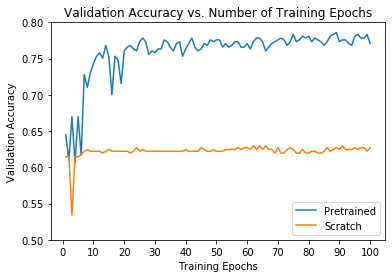

In [42]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),acc_hist,label="Pretrained")
plt.plot(range(1,num_epochs+1),sacc_hist,label="Scratch")
plt.ylim((0.5,0.8))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()

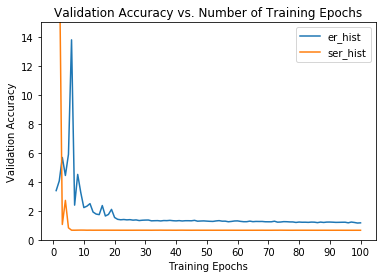

In [43]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),loss_hist,label="er_hist")
plt.plot(range(1,num_epochs+1),sloss_hist,label="ser_hist")
plt.ylim(0,15)
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()

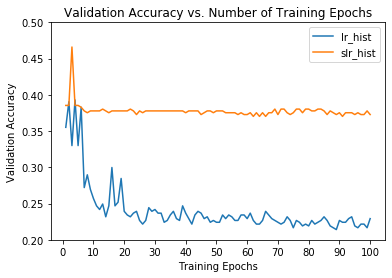

In [40]:
#  Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),err_hist,label="lr_hist")
plt.plot(range(1,num_epochs+1),serr_hist,label="slr_hist")
plt.ylim((0.2,0.5))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()


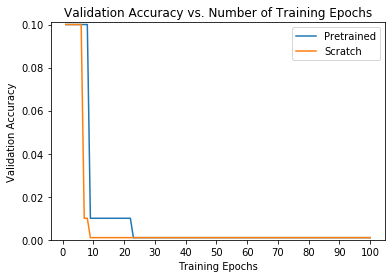

In [41]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")

plt.plot(range(1,num_epochs+1),lr_hist,label="Pretrained")
plt.plot(range(1,num_epochs+1),slr_hist,label="Scratch")
plt.ylim((0,0.101))
plt.xticks(np.arange(0, num_epochs+1, 10))
plt.legend()
plt.show()